In [51]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
import torchvision
from PIL import Image
from torchvision import models, transforms

In [15]:
os.getcwd()

'/home/jupyter-st126490/assignment3'

In [16]:
asm1_img = cv2.imread('./data/asm-1.jpg')

In [17]:
asm1_img.shape

(428, 639, 3)

In [19]:
img_rgb = cv2.cvtColor(asm1_img, cv2.COLOR_BGR2RGB)

### Using YOLO for first subtask: Generate a Bounding Box

In [22]:
model = YOLO("yolov8s.pt") 
results = model(img_rgb, conf=0.8)[0]


0: 448x640 1 person, 1 bicycle, 14.4ms
Speed: 2.6ms preprocess, 14.4ms inference, 3.7ms postprocess per image at shape (1, 3, 448, 640)


In [28]:
person_boxes = []
for box in results.boxes:
    cls = int(box.cls[0])
    if cls == 0:  # class 0 = person
        x1, y1, x2, y2 = box.xyxy[0].int().tolist()
        person_boxes.append((x1, y1, x2 - x1, y2 - y1))

if len(person_boxes) == 0:
    raise Exception("No person detected in image!")

# choose the largest bounding box
bx, by, bw, bh = max(person_boxes, key=lambda b: b[2] * b[3])
rect = (bx, by, bw, bh)
print("Bounding box:", bx, by, bw, bh)

Bounding box: 261 64 91 236


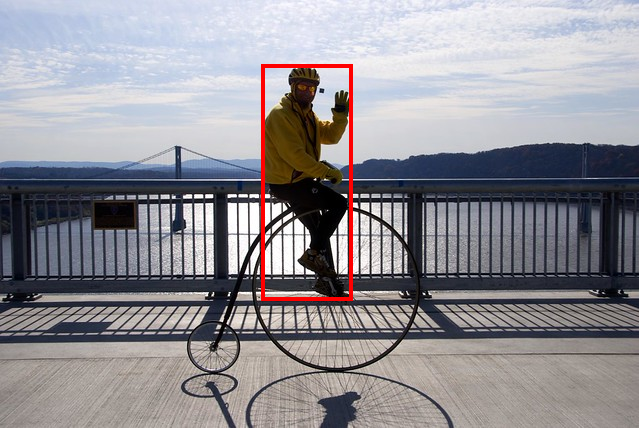

In [38]:
from PIL import Image, ImageDraw

det_img = Image.fromarray(img_rgb)
draw = ImageDraw.Draw(det_img)

draw.rectangle([bx, by, bx+bw, by+bh], outline="red", width=4)

det_img.show() 

# Interactive Foreground Extraction using GrabCut Algorithm
* https://docs.opencv.org/3.4/d8/d83/tutorial_py_grabcut.html

In [42]:
results_fg = []

mask = np.zeros(img_rgb.shape[:2], np.uint8)
bgModel = np.zeros((1, 65), np.float64)
fgModel = np.zeros((1, 65), np.float64)

cv2.grabCut(img_rgb, mask, rect, bgModel, fgModel, it, cv2.GC_INIT_WITH_RECT)

# convert mask → foreground binary mask
fg_mask = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")

fg_result = img_rgb * fg_mask[:, :, None]
results_fg.append((it, fg_mask, fg_result))

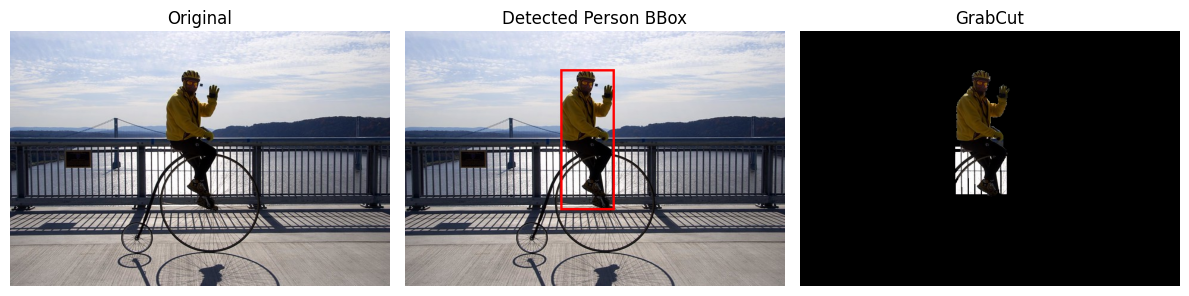

In [44]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1); plt.imshow(img_rgb); plt.title("Original"); plt.axis('off')
plt.subplot(2, 3, 2); plt.imshow(det_img); plt.title("Detected Person BBox"); plt.axis('off')

idx = 3
for it, fg_mask, fg_img in results_fg:
    plt.subplot(2, 3, idx); plt.imshow(fg_img); plt.title(f"GrabCut"); plt.axis('off')
    idx += 1

plt.tight_layout()
plt.show()

### Trying out other pre-trained model (Single Shot Detector — MobileNet-SSD) alternative to YOLO

https://github.com/opencv/opencv_extra/tree/master/testdata/dnn

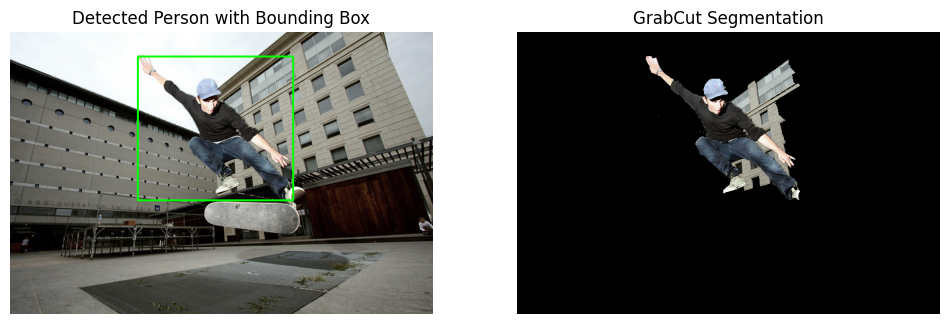

In [53]:
# Load SSD model
ssd = models.detection.ssd300_vgg16(pretrained=True).eval()

# Load image and preprocess
image_path = "./data/asm-2.jpg"
image = Image.open(image_path).convert("RGB")
orig_image = cv2.imread(image_path)  # For OpenCV processing (BGR)
(h_orig, w_orig) = orig_image.shape[:2]

transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])
img_tensor = transform(image).unsqueeze(0)

#  Run detection
with torch.no_grad():
    detections = ssd(img_tensor)[0]

boxes = detections['boxes']
labels = detections['labels']
scores = detections['scores']

# Find the first 'person'
#    In COCO, 'person' = label 1
person_box = None
for box, label, score in zip(boxes, labels, scores):
    if label.item() == 1 and score.item() > 0.5:  # person with confidence > 0.5
        x1, y1, x2, y2 = box
        # Scale box back to original image size
        x1 = int(x1 / 300 * w_orig)
        x2 = int(x2 / 300 * w_orig)
        y1 = int(y1 / 300 * h_orig)
        y2 = int(y2 / 300 * h_orig)
        person_box = (x1, y1, x2, y2)
        break

if person_box is None:
    raise Exception("No person detected!")

image_with_box = orig_image.copy()
x, y, x2, y2 = person_box
cv2.rectangle(image_with_box, (x, y), (x2, y2), (0, 255, 0), 2)

# Prepare mask for grabCut
mask = np.zeros(orig_image.shape[:2], np.uint8)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

rect = (x, y, x2 - x, y2 - y)
cv2.grabCut(orig_image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
segmented = orig_image * mask2[:, :, np.newaxis]

# Display results inline

# Convert BGR → RGB for matplotlib
image_with_box_rgb = cv2.cvtColor(image_with_box, cv2.COLOR_BGR2RGB)
segmented_rgb = cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_with_box_rgb)
plt.axis('off')
plt.title("Detected Person with Bounding Box")

plt.subplot(1, 2, 2)
plt.imshow(segmented_rgb)
plt.axis('off')
plt.title("GrabCut Segmentation")

plt.show()

## Trying Faster RCNN for the same

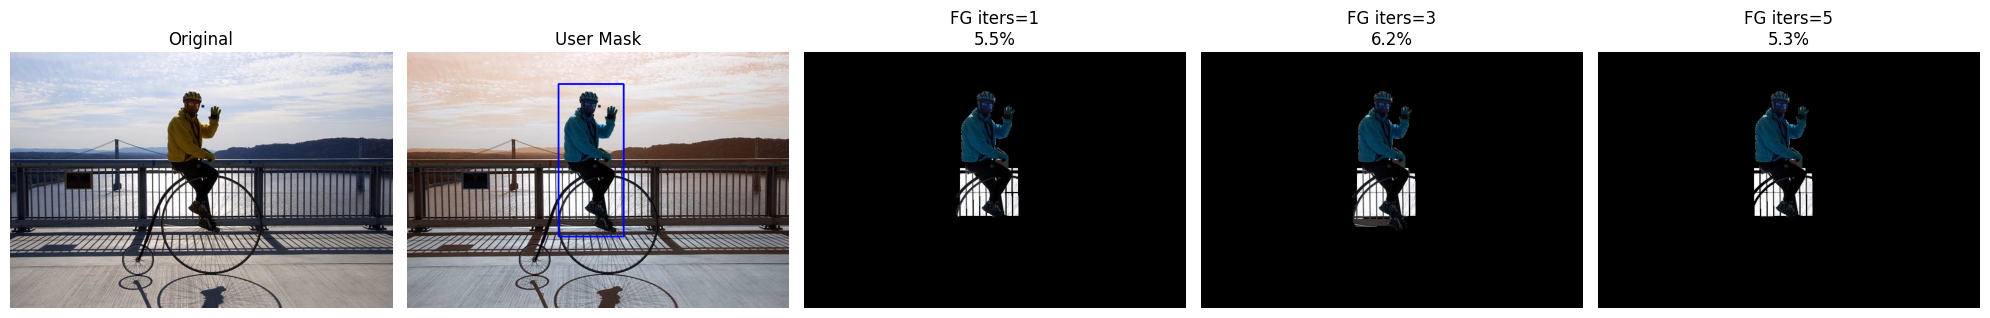

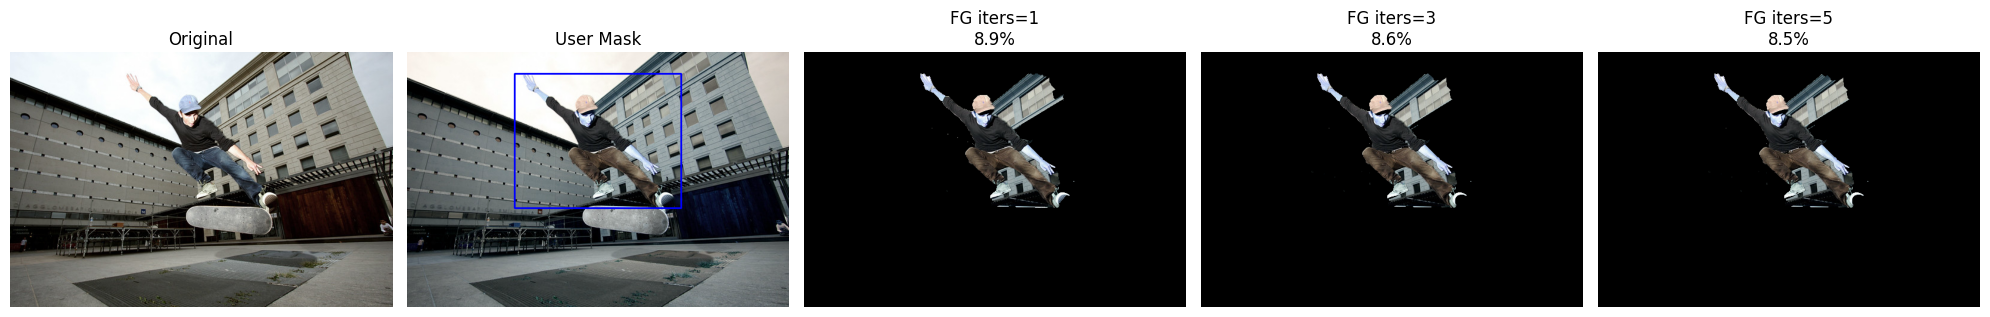

In [59]:
def grabcut_with_iterations(img_np, rect, iterations_list=[1,3,5]):
    results = []
    h, w = img_np.shape[:2]
    
    for iters in iterations_list:
        mask = np.zeros((h, w), np.uint8)
        bgdModel = np.zeros((1,65), np.float64)
        fgdModel = np.zeros((1,65), np.float64)
        cv2.grabCut(img_np, mask, rect, bgdModel, fgdModel, iters, cv2.GC_INIT_WITH_RECT)
        mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
        fg_only = img_np * mask2[:, :, np.newaxis]
        overlay = img_np.copy()
        overlay[mask2==0] = (0,0,0)
        fg_percent = mask2.sum() / (h*w) * 100
        results.append((iters, mask2, fg_only, overlay, fg_percent))
    return results

def detect_person_bbox(img_path, model, margin=10):
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)
    h_orig, w_orig = img_np.shape[:2]
    tensor = torchvision.transforms.functional.to_tensor(img)
    with torch.no_grad():
        outputs = model([tensor])[0]
    boxes = outputs['boxes']
    labels = outputs['labels']
    scores = outputs['scores']
    person_boxes = [(box, score) for box, label, score in zip(boxes, labels, scores)
                    if label==1 and score>0.5]
    if len(person_boxes)==0:
        raise Exception(f"No person detected in {img_path}")
    best_box, _ = max(person_boxes, key=lambda x:x[1])
    bx1, by1, bx2, by2 = best_box.int().tolist()
    bw, bh = bx2-bx1, by2-by1

    # Add margin and clamp to image bounds
    x = max(bx1 - margin, 0)
    y = max(by1 - margin, 0)
    w = min(bw + 2*margin, w_orig - x)
    h = min(bh + 2*margin, h_orig - y)
    rect = (x, y, w, h)
    return img, img_np, rect

# load Faster R-CNN once
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
model.eval()

images = ["./data/asm-1.jpg","./data/asm-2.jpg"]

for img_path in images:
    img, img_np, rect = detect_person_bbox(img_path, model, margin=10)
    results = grabcut_with_iterations(img_np, rect, [1,3,5])
    
    fig, axes = plt.subplots(1, 2+len(results), figsize=(4*(2+len(results)),5))

    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title("Original")
    
    mask_vis = img_np.copy()
    x, y, w, h = rect
    cv2.rectangle(mask_vis, (x, y), (x+w, y+h), (255,0,0), 2)
    axes[1].imshow(cv2.cvtColor(mask_vis, cv2.COLOR_BGR2RGB))
    axes[1].axis('off')
    axes[1].set_title("User Mask")
    
    for i, (iters, mask2, fg_only, overlay, fg_percent) in enumerate(results):
        axes[2+i].imshow(cv2.cvtColor(fg_only, cv2.COLOR_BGR2RGB))
        axes[2+i].axis('off')
        axes[2+i].set_title(f"FG iters={iters}\n{fg_percent:.1f}%")
    
    plt.tight_layout()
    plt.show()

# Looking at the random % of FG iterations:
GrabCut is iterative but stochastic

Internally it uses Gaussian Mixture Models (GMMs) to classify foreground and background.

In some iterations, some boundary pixels may get reclassified as background, reducing the foreground pixel count.

More iterations don’t guarantee a monotonic increase in foreground coverage.


In short:

Random-looking percentages are normal, especially with complex images.

The visual segmentation is the better metric here.

